# Turku Public Transport Analysis

This notebook explores passenger counts for Turku's bus system in 2024.

The goal is to find busiest and quietest days, compare riderships in different seasons and days of the week, and find busiest stops and routes throughout the year.


We start from doing all the necessary imports.

In [104]:
from pathlib import Path
import sys
import webbrowser
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import folium
import pandas as pd
import seaborn as sns
import datetime
import holidays
import geopandas as gpd
from shapely.geometry import Point
import contextily as ctx
import matplotlib.colors as mcolors


In [105]:
PROJECT_DIR = Path(".").resolve().parent 
DATA_DIR = PROJECT_DIR / "data"
SCRIPTS_DIR = PROJECT_DIR / "scripts"
sys.path.append(str(SCRIPTS_DIR))

HTML_DIR = PROJECT_DIR / "html_outputs"
HTML_DIR.mkdir(exist_ok=True)

# Load and Prepare Data

We now load the passenger trip data and stop metadata.

Source: https://www.avoindata.fi/data/en_GB/dataset/turun-seudun-joukkoliikenteen-kayttajamaaria

The `load_clean_data` function loads the CSV file with trips data and JSON file with stops data and merges them together. It also fills missing stop names with a placeholder.

In [106]:
from load_and_merge import load_clean_data

ext_data_2024, data_2024, stops, missing_stops_2024 = load_clean_data(
    DATA_DIR / "2024-foli.csv",
    DATA_DIR / "stops.json"
)

ext_data_2024 = ext_data_2024.copy()

# Basic Overview

Let's have a look at the dataset structure.


In [107]:
print(ext_data_2024.head())
print(ext_data_2024.info())

        date line  stop  count      stop_name  stop_lat  stop_lon zone_id  \
0 2024-01-02   99   778      5  Pansion koulu  60.44966  22.16755    FÖLI   
1 2024-01-02   99  1708      5      Katariina  60.41308  22.28881    FÖLI   
2 2024-01-02   99  1494      5      Sävelkuja  60.41913  22.30184    FÖLI   
3 2024-01-02   99   888      5  Kraatarinkatu  60.44665  22.35355    FÖLI   
4 2024-01-02   99   840      5      Jaaninoja  60.44630  22.32770    FÖLI   

     stop_timezone stop_name_filled  
0  Europe/Helsinki    Pansion koulu  
1  Europe/Helsinki        Katariina  
2  Europe/Helsinki        Sävelkuja  
3  Europe/Helsinki    Kraatarinkatu  
4  Europe/Helsinki        Jaaninoja  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 773470 entries, 0 to 773469
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   date              773470 non-null  datetime64[ns]
 1   line              773470 non

So our data includes measurement day, line number, stop number, number of passengers boarding the given bus line on the given stop during the given day (count), stop name, stop coordinates, zone id, stop timezone (Helsinki) and filled stop name ("Unknown stop" if the stop is not in the stops data.)

We will also keep the unmerged data: data_2024 dataframe contains information about ridership in 2024, and stops dataframe contains information about stops.

In [108]:
print(data_2024.head())
print(stops.head())

        date line  stop  count
0 2024-01-02   99   778      5
1 2024-01-02   99  1708      5
2 2024-01-02   99  1494      5
3 2024-01-02   99   888      5
4 2024-01-02   99   840      5
   stop_id             stop_name  stop_lat  stop_lon zone_id    stop_timezone
0        1  Turun satama (Silja)  60.43497  22.21966    FÖLI  Europe/Helsinki
1       10   Sairashuoneenpuisto  60.44419  22.25233    FÖLI  Europe/Helsinki
2      100        Wärtsilänpolku  60.43482  22.24424    FÖLI  Europe/Helsinki
3     1000           Takamaantie  60.43086  22.27303    FÖLI  Europe/Helsinki
4     1001           Jäkäläpolku  60.42836  22.27117    FÖLI  Europe/Helsinki


Let's now check if there is some stop data missing.

In [109]:
print(f"Missing stops: {missing_stops_2024}")

Missing stops: [1048, 1441, 167, 942, 1682, 219, 1670, 280, 332, 801, 941, 867, 331, 991, 2011, 665, 617, 847, 1030, 279, 688, 521, 849, 1017, 713, 1028, 869, 1050, 686, 638, 929, 717, 2012, 851, 296, 1679, 536, 1672, 1694, 685, 1516, 1623, 1500, 6319, 916, 220, 1051, 1484, 6350, 1975, 5136, 6267, 1482, 6276, 429, 520, 6278, 580, 6400, 439, 6270, 6268, 6320, 6305, 1673, 1122, 1676, 6266, 1521, 999, 6272, 6265, 1622, 579, 6307, 6280, 803, 2145, 6318, 1979, 1978, 498, 554, 603, 1059, 1775, 1519]


We see that there are quite a few stops appearing in the data_2024 dataframe, but not in stops dataframe. We will keep them in ext_data_2024, although their coordinates and names are unknown. 

Let's calculate the total number of passenger trips recorded in 2024.


In [110]:
total_passengers = ext_data_2024['count'].sum()
print(f"The total number of trips in 2024: {total_passengers :,}")

The total number of trips in 2024: 24,807,995


We see that around 25 million trips were recorded in 2024.

Let's check which days are represented in the dataset.




In [111]:
print(f"Years represented: {ext_data_2024['date'].dt.year.unique()}")
print(f"Number of different dates represented: {ext_data_2024['date'].nunique()}")
print(f"Earliest date: {ext_data_2024['date'].min().date()}")
print(f"Latest date: {ext_data_2024['date'].max().date()}")


Years represented: [2024]
Number of different dates represented: 365
Earliest date: 2024-01-02
Latest date: 2024-12-31


We see that all the represented dates are indeed in 2024, and the data covers the whole year except for Jan. 1st (2024 was a leap year). Since Jan. 1st data is not present, we omit it from consideration.

Let's now look at the ridership per day and identify busiest and quietest days, according to the data.

In [112]:
pass_by_date = ext_data_2024.groupby('date')['count'].sum()

busiest_day = pass_by_date.idxmax().date()
quietest_day = pass_by_date.idxmin().date()

busiest_day_count = pass_by_date.max()
quietest_day_count = pass_by_date.min()

avg_rid = pass_by_date.mean().round(2)

print(f"The biggest amount of rides was recorded on {busiest_day}, with {busiest_day_count} rides.")
print(f"The smallest amount of rides was recorded on {quietest_day}, with {quietest_day_count} rides.")
print(f"The average ridership in 2024 is {avg_rid}.")

The biggest amount of rides was recorded on 2024-11-22, with 110532 rides.
The smallest amount of rides was recorded on 2024-12-31, with 242 rides.
The average ridership in 2024 is 67967.11.


We see that the busiest day was November 22nd. Allegedely the quietest day was December 31d, but the data from Dec. 31d looks incomplete, since the amount of recorded rides is suspiciously small (even for New Year's Eve).



In [113]:
pass_top =  pass_by_date.sort_values(ascending=False).head()
pass_top_reset = pass_top.reset_index()
pass_top_reset.columns = ['Date', 'Rides']
print("Five busiest days:")
display(pass_top_reset.style.hide(axis="index").format({
    "Date": lambda d: d.strftime('%Y-%m-%d'),
    "Rides": "{:,}"
}))



Five busiest days:


Date,Rides
2024-11-22,"110,532"
2024-12-13,"108,655"
2024-12-05,"108,030"
2024-12-04,"107,210"
2024-11-29,"106,735"


We see that all of them are in December (pre-Christmas) or late November, when people do a lot of Christmas shopping.

In [114]:
pass_bottom =  pass_by_date.sort_values(ascending=True).head()
pass_bottom_reset = pass_bottom.reset_index()
pass_bottom_reset.columns = ['Date', 'Rides']
print("Five quietest days:")
display(pass_bottom_reset.style.hide(axis="index").format({
    "Date": lambda d: d.strftime('%Y-%m-%d'),
    "Rides": "{:,}"
}))

Five quietest days:


Date,Rides
2024-12-31,242
2024-12-25,"9,875"
2024-12-24,"19,794"
2024-06-22,"20,232"
2024-06-23,"21,143"


Christmas day (Dec. 25st) had much less recorded rides than the other days (except Dec. 31rd where the data seems incomplete). Also Christmas Eve (Dec. 24st) and Midsummer weekend (June 22nd and 23d) have low ridership. 


# Ridership per day of the week

Let's now analyze the ridership on different days of the week. The goal is to see how significant is the ridership drop on weekends compared to weekdays, and whether Sunday ridership differs much from Saturday.

We will start by adding to ext_data_2024 two columns which say what the day of the week is ('day') and whether it is workday or weekend ('day_type').

In [115]:

ext_data_2024['day'] = ext_data_2024['date'].dt.day_name()
ext_data_2024['day_type'] = np.where(ext_data_2024['day'].isin(['Saturday', 'Sunday']), 'Weekend', 'Workday')


One can see how it appears in ext_data_2024 table.

In [116]:
print(ext_data_2024.head())

        date line  stop  count      stop_name  stop_lat  stop_lon zone_id  \
0 2024-01-02   99   778      5  Pansion koulu  60.44966  22.16755    FÖLI   
1 2024-01-02   99  1708      5      Katariina  60.41308  22.28881    FÖLI   
2 2024-01-02   99  1494      5      Sävelkuja  60.41913  22.30184    FÖLI   
3 2024-01-02   99   888      5  Kraatarinkatu  60.44665  22.35355    FÖLI   
4 2024-01-02   99   840      5      Jaaninoja  60.44630  22.32770    FÖLI   

     stop_timezone stop_name_filled      day day_type  
0  Europe/Helsinki    Pansion koulu  Tuesday  Workday  
1  Europe/Helsinki        Katariina  Tuesday  Workday  
2  Europe/Helsinki        Sävelkuja  Tuesday  Workday  
3  Europe/Helsinki    Kraatarinkatu  Tuesday  Workday  
4  Europe/Helsinki        Jaaninoja  Tuesday  Workday  


Let's now look at average ridership per day of the week and on workdays vs weekends.

In [117]:
pass_by_date = ext_data_2024.groupby('date')['count'].sum()
pass_by_date_df = pass_by_date.reset_index()
pass_by_date_df['day'] = pass_by_date_df['date'].dt.day_name()

In [118]:
avg_per_day = pass_by_date_df.groupby('day')['count'].mean().round(0)
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
avg_per_day_sorted = avg_per_day.reindex(days_order)
avg_per_day_sorted = avg_per_day_sorted.reset_index()
avg_per_day_sorted.columns = ['Day of the week', 'Average number of rides']
print("Average ridership in 2024 per day of the week:")
display(avg_per_day_sorted.style.hide(axis="index").format({
    "Average number of rides": "{:,.0f}"
})) 


Average ridership in 2024 per day of the week:


Day of the week,Average number of rides
Monday,"77,466"
Tuesday,"79,472"
Wednesday,"80,336"
Thursday,"80,538"
Friday,"80,785"
Saturday,"48,097"
Sunday,"28,855"


Let's make a visualization to see it more clearly.

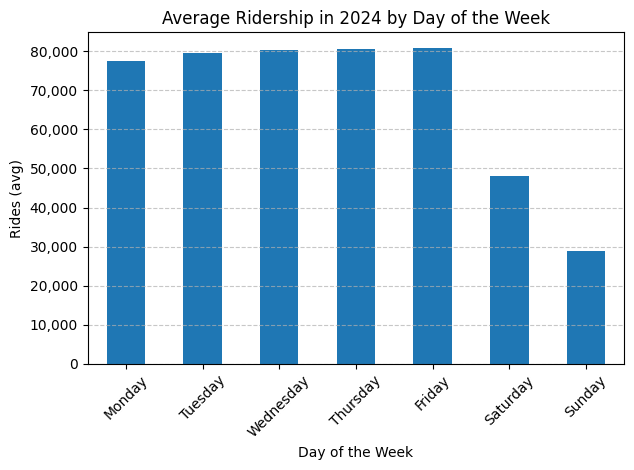

In [119]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick


avg_per_day_sorted.plot(kind='bar', x='Day of the week', y='Average number of rides', legend=False)
plt.title('Average Ridership in 2024 by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Rides (avg)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.gca().yaxis.set_major_formatter(
    mtick.FuncFormatter(lambda x, _: f'{x:,.0f}')
)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

We see that weekday ridership rises slightly through the week, peaking on Friday. Weekend travel is much lighter: Saturday averages about 40 % fewer rides than Friday, and Sunday roughly 40 % fewer than Saturday.

To make the comparison more clear we also compute average ridership on weekdays and weekends.

In [120]:
pass_by_date_df['day_type'] = np.where(pass_by_date_df['day'].isin(['Saturday', 'Sunday']), 'Weekend day', 'Weekday')
avg_per_day_type = pass_by_date_df.groupby('day_type')['count'].mean().round(0)
avg_per_day_type = avg_per_day_type.reset_index()
avg_per_day_type.columns = ['Day type', 'Average number of rides']

avg_pass = pass_by_date_df['count'].mean().round(0)
avg_pass_df = pd.DataFrame({'Day type': ['All days'], 'Average number of rides': [avg_pass]})
avg_per_day_type = pd.concat([avg_per_day_type, avg_pass_df])

print("Average ridership in 2024 on weekend days (Sat-Sun) vs weekdays (Mon-Fri):")
display(avg_per_day_type.style.hide(axis="index").format({
    "Average number of rides": "{:,.0f}"
})) 


Average ridership in 2024 on weekend days (Sat-Sun) vs weekdays (Mon-Fri):


Day type,Average number of rides
Weekday,"79,718"
Weekend day,"38,476"
All days,"67,967"


We see that the average ridership on weekends was about a half of the average ridership on a workday.

Let's now also take Finnish public holidays into account.

In [121]:
import holidays
hol = holidays.Finland(years=2024)
holiday_dates = set(hol.keys()) 

pass_by_date = ext_data_2024.groupby('date')['count'].sum()
pass_by_date_df = pass_by_date.reset_index()

pass_by_date_df['is_holiday'] = pass_by_date_df['date'].dt.date.isin(holiday_dates)
data_by_holiday = pass_by_date_df.groupby('is_holiday')['count'].mean().round(0)

holiday_df = data_by_holiday.reset_index()
holiday_df.columns = ['Day type', 'Average number of rides']

holiday_df['Day type'] = holiday_df['Day type'].map({True: 'Holiday', False: 'Non-holiday'})
display(holiday_df.style.hide(axis='index').format({
    'Average number of rides': '{:,.0f}'
}))




Day type,Average number of rides
Non-holiday,"69,511"
Holiday,"29,263"


We see that the average ridership on a holiday day is about 40% of the ridership on a non-holiday day.



Now we will compare ridership on regular weekdays, Saturdays, Sundays and holidays.

In [122]:
pass_by_date = ext_data_2024.groupby('date')['count'].sum()
pass_by_date_df = pass_by_date.reset_index()
pass_by_date_df['day'] = pass_by_date_df['date'].dt.day_name()
holiday_dates = set(hol.keys())
pass_by_date_df['is_holiday'] = pass_by_date_df['date'].dt.date.isin(holiday_dates)

import numpy as np
conditions = [pass_by_date_df['is_holiday'],
              pass_by_date_df['day'] == 'Saturday',
              pass_by_date_df['day'] == 'Sunday']
choices = ['Holiday', 'Saturday (not holiday)', 'Sunday (not holiday)']
pass_by_date_df['day_type'] = np.select(conditions, choices, default='Workday')



In [123]:
avg_per_day_type = pass_by_date_df.groupby('day_type')['count'].mean().round(0)
avg_per_day_type = avg_per_day_type.reset_index()
avg_per_day_type.columns = ['Day type', 'Average number of rides']


print("Average ridership in 2024 by day type:")
display(avg_per_day_type.style.hide(axis="index").format({
    "Average number of rides": "{:,.0f}"
})) 

Average ridership in 2024 by day type:


Day type,Average number of rides
Holiday,"29,263"
Saturday (not holiday),"48,916"
Sunday (not holiday),"28,925"
Workday,"81,568"


We add a visualization to make it more clear.

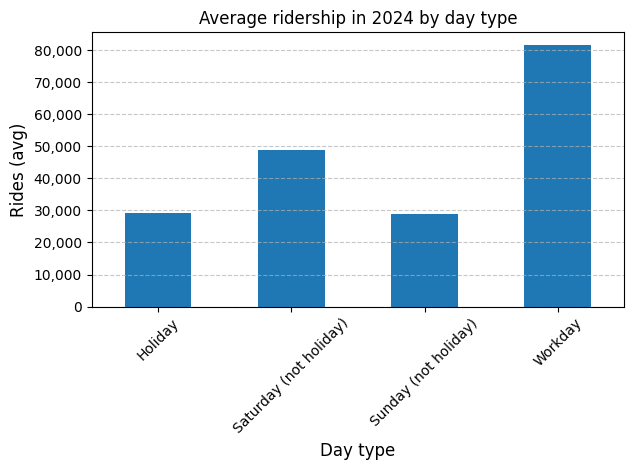

In [124]:
avg_per_day_type.plot(kind='bar', x='Day type', y='Average number of rides', legend=False)
plt.title('Average ridership in 2024 by day type')
plt.xlabel('Day type', fontsize=12)
plt.ylabel('Rides (avg)', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.gca().yaxis.set_major_formatter(
    mtick.FuncFormatter(lambda x, _: f'{x:,.0f}')
)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

We see that holidays are on average quite close to regular Sundays in terms of ridership.

# Ridership trends throughout the year

Let's now analyze how ridership varies in different months and seasons.

In [125]:
pass_by_date = ext_data_2024.groupby('date')['count'].sum()
pass_by_date_df = pass_by_date.reset_index()
pass_by_date_df['month'] = pass_by_date_df['date'].dt.month_name()
avg_by_month = pass_by_date_df.groupby('month')['count'].mean().round(0)
months_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
avg_by_month = avg_by_month.reindex(months_order)

avg_by_month = avg_by_month.reset_index()
avg_by_month.columns = ['Month', 'Number of day rides (avg)']

print("Average day ridership in 2024 by month:")
display(avg_by_month.style.hide(axis="index").format({
    "Number of day rides (avg)": "{:,.0f}"
})) 

Average day ridership in 2024 by month:


Month,Number of day rides (avg)
January,"77,240"
February,"71,193"
March,"76,352"
April,"74,400"
May,"65,077"
June,"48,960"
July,"48,822"
August,"62,176"
September,"69,724"
October,"73,581"


Let's visualize it.

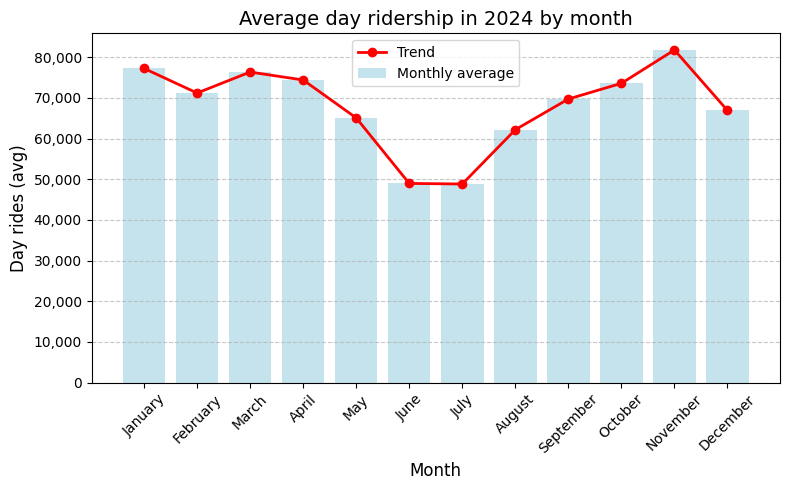

In [126]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

fig, ax = plt.subplots(figsize=(8,5))

# Bar chart
ax.bar(avg_by_month['Month'], avg_by_month['Number of day rides (avg)'],
       color='lightblue', alpha=0.7, label='Monthly average')

# Line overlay
ax.plot(avg_by_month['Month'], avg_by_month['Number of day rides (avg)'],
        color='red', marker='o', linewidth=2, label='Trend')

ax.set_title('Average day ridership in 2024 by month', fontsize=14)
ax.set_xlabel('Month', fontsize=12)
ax.set_ylabel('Day rides (avg)', fontsize=12)
ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'{x:,.0f}'))
ax.grid(axis='y', linestyle='--', alpha=0.7)
ax.set_ylim(bottom=0)
plt.xticks(rotation=45)
plt.tight_layout()
plt.legend()
plt.show()


We can see that the ridership in 2024 shows clear seasonality.
Demand is steady in the first quarter, then falls sharply during the summer holiday months (June–July), and then rebounds in late summer (when kids go to school in early August). 
The highest average ridership occurs in November, likely due to pre-Christmas activity.

Let's also look at the ridership per season.

In [127]:
pass_by_date = ext_data_2024.groupby('date')['count'].sum()
pass_by_date_df = pass_by_date.reset_index()
pass_by_date_df['month'] = pass_by_date_df['date'].dt.month_name()
conditions = [pass_by_date_df['month'].isin(['December', 'January', 'February']),
              pass_by_date_df['month'].isin(['March', 'April', 'May']),
              pass_by_date_df['month'].isin(['June', 'July', 'August']),
              pass_by_date_df['month'].isin(['September', 'October', 'November'])]
choices = ['Winter', 'Spring', 'Summer', 'Autumn']
pass_by_date_df['season'] = np.select(conditions, choices, default='Unknown')

avg_by_season = pass_by_date_df.groupby('season')['count'].mean().round(0)
season_order = ['Winter', 'Spring', 'Summer', 'Autumn']
avg_by_season = avg_by_season.reindex(season_order)

avg_by_season = avg_by_season.reset_index()

avg_by_season.columns = ['Season', 'Number of day rides (avg)']

print("Average day ridership in 2024 by season:")
display(avg_by_season.style.hide(axis="index").format({
    "Number of day rides (avg)": "{:,.0f}"
})) 


Average day ridership in 2024 by season:


Season,Number of day rides (avg)
Winter,"71,731"
Spring,"71,917"
Summer,"53,367"
Autumn,"75,013"


We make a visualization.

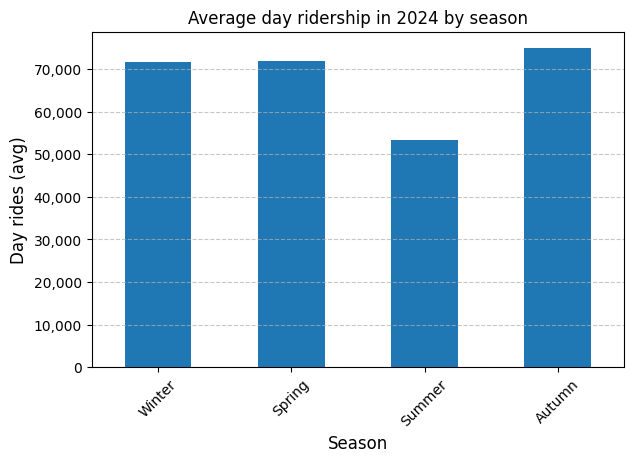

In [128]:
avg_by_season.plot(kind='bar', x='Season', y='Number of day rides (avg)', legend=False)
plt.title('Average day ridership in 2024 by season')
plt.xlabel('Season', fontsize=12)
plt.ylabel('Day rides (avg)', fontsize=12)
plt.tight_layout()
plt.gca().yaxis.set_major_formatter(
    mtick.FuncFormatter(lambda x, _: f'{x:,.0f}')
)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.ylim(bottom=0)
plt.xticks(ticks=range(len(avg_by_season)), labels=avg_by_season['Season'], rotation=45)
plt.show()

This confirms that ridership is much lower in the summer, while other seasons have rather similar ridership.

# Heatmap

We now have a look at a heatmap over days of the week and weeks.

C:\Users\zakha\AppData\Local\Temp\ipykernel_18316\2632311179.py:22: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  heatmap_data = pass_by_date_df.pivot_table(


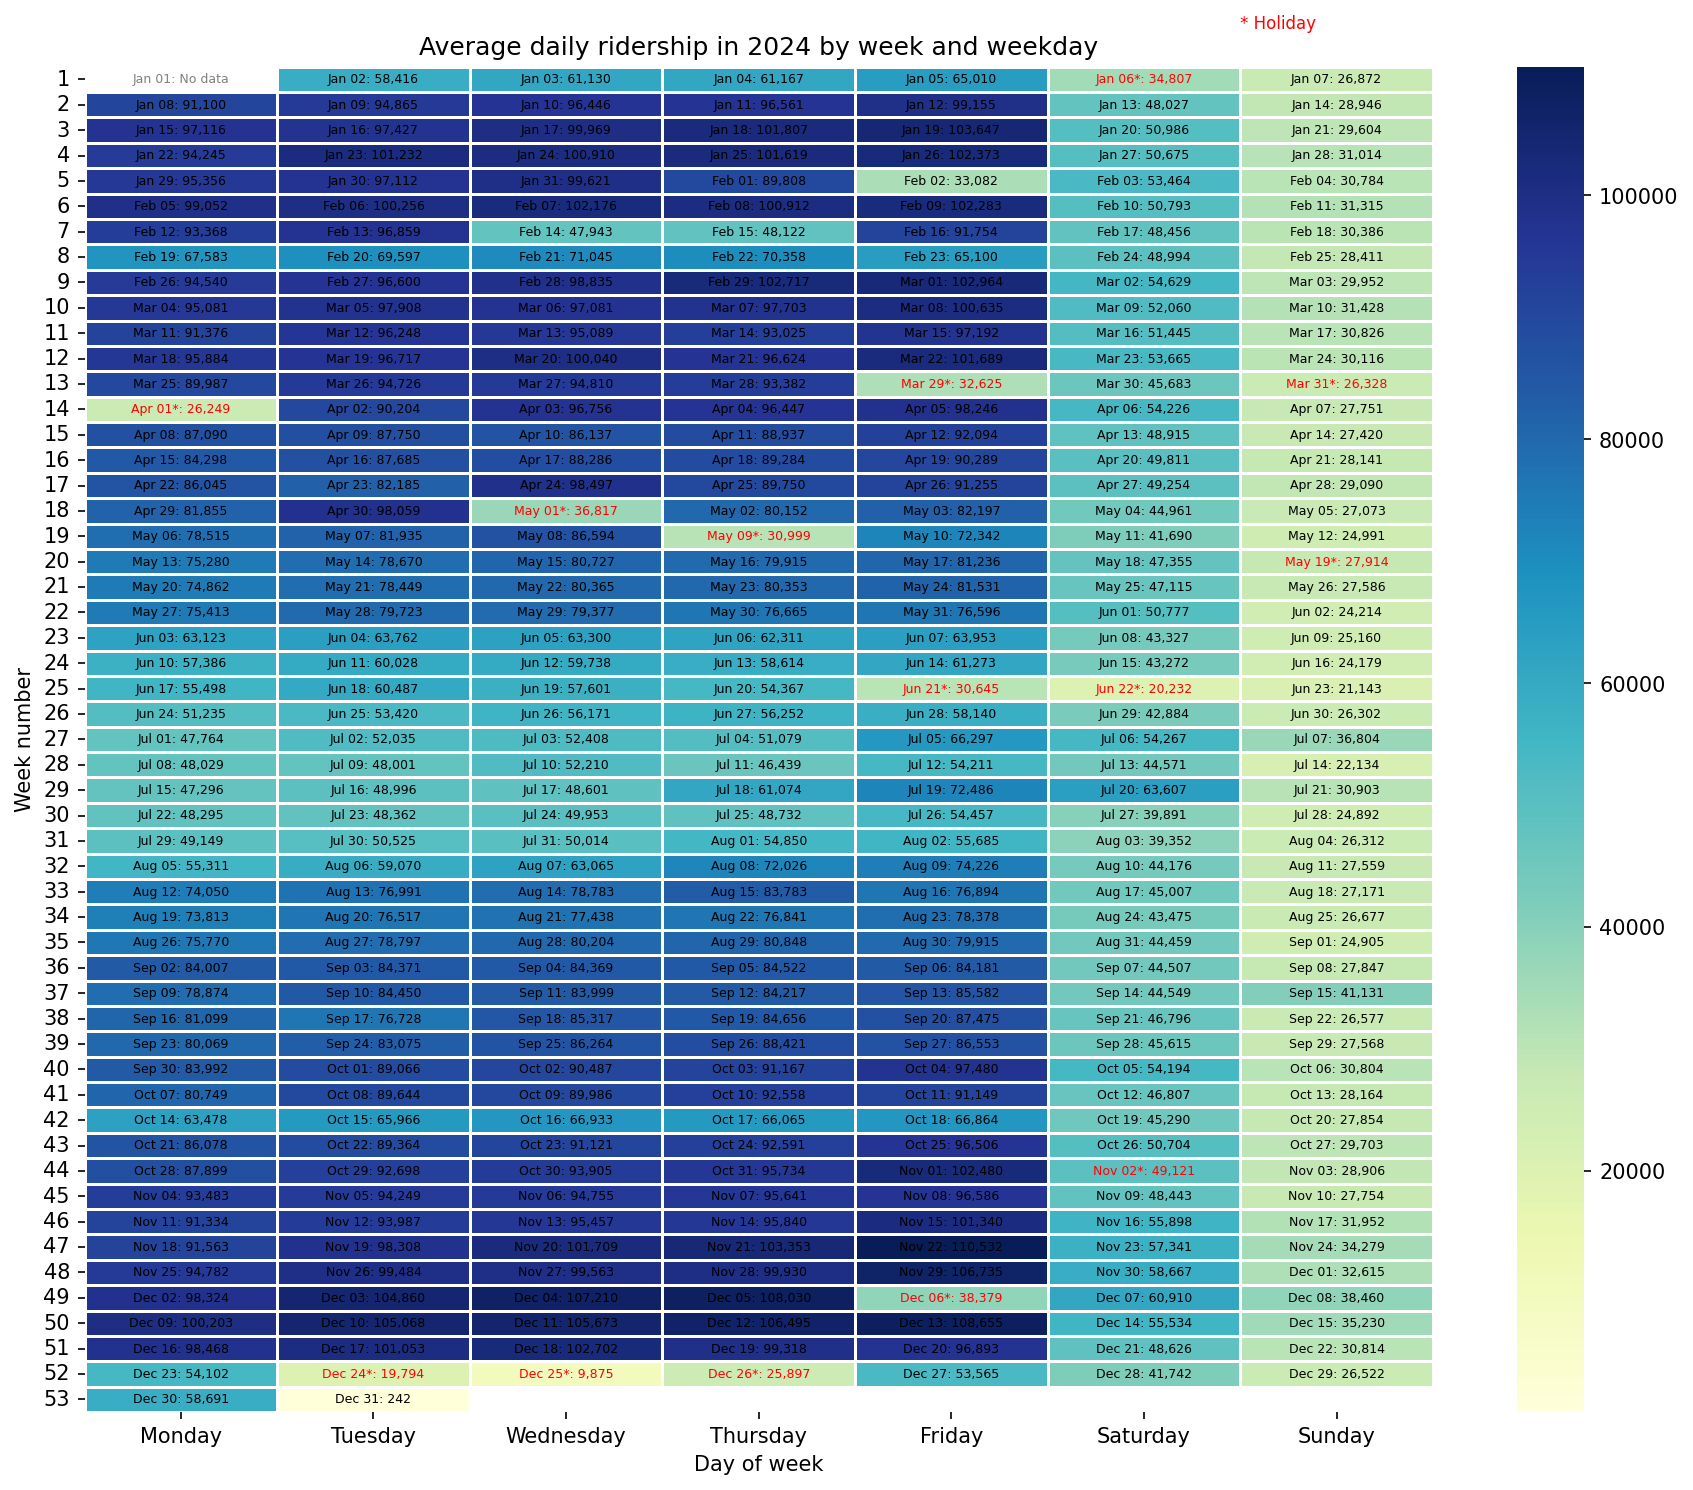

In [129]:

pass_by_date_df['date'] = pd.to_datetime(pass_by_date_df['date'])

jan1 = pd.DataFrame({
    'date': [pd.to_datetime('2024-01-01')],
    'count': [float('nan')]
})
pass_by_date_df = pd.concat([jan1, pass_by_date_df], ignore_index=True)

first_monday = pd.to_datetime('2024-01-01')
while first_monday.weekday() != 0:
    first_monday += pd.Timedelta(days=1)


pass_by_date_df['week_number'] = ((pass_by_date_df['date'] - first_monday).dt.days // 7 + 1).astype(int)

pass_by_date_df.loc[pass_by_date_df['date'] == pd.to_datetime('2024-01-01'), 'week_number'] = 0

pass_by_date_df['day_of_week'] = pass_by_date_df['date'].dt.day_name()
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
pass_by_date_df['day_of_week'] = pd.Categorical(pass_by_date_df['day_of_week'], categories=days_order, ordered=True)

heatmap_data = pass_by_date_df.pivot_table(
    index='week_number',
    columns='day_of_week',
    values='count',
    aggfunc='mean'
)

finland_holidays = set(holidays.Finland(years=2024).keys())

plt.figure(figsize=(12, 10), dpi=150)
sns.heatmap(
    heatmap_data,
    cmap='YlGnBu',
    linewidths=0.5,
    cbar=True,
    fmt='.0f',
    mask=heatmap_data.isnull(),
    square=False,
    vmin=heatmap_data.min().min(),
    vmax=heatmap_data.max().max()
)

for y_idx, week in enumerate(heatmap_data.index):
    for x_idx, day in enumerate(heatmap_data.columns):
        try:
            if week == 0:
                date = datetime.date(2024, 1, 1)
            else:
                date = (first_monday + pd.Timedelta(weeks=week - 1, days=x_idx)).date()

            is_holiday = date in finland_holidays
            count = heatmap_data.loc[week, day]

            if pd.isna(count):
                if date == datetime.date(2024, 1, 1):
                    label = "Jan 01: No data"
                    color = 'gray'
                else:
                    continue
            else:
                date_str = date.strftime('%b %d') + ('*' if is_holiday else '')
                label = f"{date_str}: {int(round(count)):,}"
                color = 'red' if is_holiday else 'black'

            plt.text(
                x_idx + 0.5, y_idx + 0.5,
                label,
                ha='center', va='center',
                fontsize=6,
                color=color
            )
        except Exception:
            continue

plt.title('Average daily ridership in 2024 by week and weekday')
plt.ylabel('Week number')
plt.xlabel('Day of week')
plt.text(len(days_order) - 1, -1.5, '* Holiday', color='red', fontsize=8)
plt.tight_layout()
plt.show()



We see again a notable drop in ridership during June and July, which aligns with the summer school holidays (01.06.2024 – 07.08.2024). Other school holidays also correspond to dips in ridership:
- Christmas holidays: until 07.01.2024 and from 21.12.2024 onward  
- Winter holidays: 19.02.2024 – 23.02.2024  
- Autumn holidays: 14.10.2024 – 18.10.2024  


#### Lower-than-expected ridership (outliers) and likely reasons:
- 02.02.2024 – Strike  
- 14–15.02.2024 – Strike 
- 31.12.2024 – Unusually low; likely a data error  

#### Higher-than-expected ridership (outliers) and likely reasons:
- 30.04.2024 – Vappu Eve (May Day celebrations)  
- 05–07.07.2024 – Ruisrock Festival  
- 18–21.07.2024 – Tall Ships Races in Turku  
- 15.09.2024 – Day of Turku (local city celebration)  


Let us now check the average ridership on schooldays vs other workdays. 

In [130]:

school_holidays = [
    pd.date_range('2024-06-01', '2024-08-07'),  
    pd.date_range('2024-01-01', '2024-01-07'), 
    pd.date_range('2024-12-21', '2024-12-31'),  
    pd.date_range('2024-02-19', '2024-02-23'),  
    pd.date_range('2024-10-14', '2024-10-18')   
]
school_holiday_dates = pd.to_datetime(pd.concat([pd.Series(dates) for dates in school_holidays]))


finland_holidays = holidays.Finland(years=2024)
public_holiday_dates = pd.to_datetime(list(finland_holidays.keys()))


pass_by_date_df['weekday_name'] = pass_by_date_df['date'].dt.day_name()

workdays_df = pass_by_date_df[pass_by_date_df['weekday_name'].isin(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'])].copy()

workdays_df = workdays_df[~workdays_df['date'].isin(public_holiday_dates)]

workdays_df['is_school_holiday_workday'] = workdays_df['date'].isin(school_holiday_dates)

avg_school_holiday = workdays_df.loc[workdays_df['is_school_holiday_workday'], 'count'].mean()
avg_school_day = workdays_df.loc[~workdays_df['is_school_holiday_workday'], 'count'].mean()

print(f"Average ridership on workdays during school holidays (excluding public holidays): {avg_school_holiday:,.0f}")
print(f"Average ridership on workdays outside school holidays (excluding public holidays): {avg_school_day:,.0f}")




Average ridership on workdays during school holidays (excluding public holidays): 56,713
Average ridership on workdays outside school holidays (excluding public holidays): 90,208


We see that ridership on school workdays is about 60% higher than on school vacation workdays.



## Ridership by stop

Let us now analyze ridership per stop. We only have data about boardings.

First we group by stops.

In [131]:
stop_rid = ext_data_2024.groupby("stop")["count"].sum()
stop_rid_df = stop_rid.reset_index()
stop_data =  stop_rid_df.merge(stops, how='left', left_on='stop', right_on='stop_id')
stop_data.drop(columns="stop_id", inplace=True)



Now we find the busiest stops.

In [132]:
stop_top =  stop_data.sort_values(by='count', ascending=False).head(10)
stop_top_reset = stop_top.reset_index()[['stop', 'stop_name', 'count', 'stop_lat', 'stop_lon']]
stop_top_reset.columns = ['Stop', 'Stop name', 'Rides', 'Stop latitude', 'Stop longitude']
print("Ten busiest stops in 2024:")
display(stop_top_reset.style.hide(axis="index"))



Ten busiest stops in 2024:


Stop,Stop name,Rides,Stop latitude,Stop longitude
1933,Kauppatori D3,432252,60.450900,22.266240
1903,Kauppatori A3,420709,60.451040,22.266350
1901,Kauppatori A1,418907,60.451680,22.265460
1931,Kauppatori D1,387306,60.451520,22.265340
1904,Kauppatori A4,370056,60.450850,22.266810
1914,Kauppatori B4,350742,60.450850,22.267120
1934,Kauppatori D4,337888,60.450300,22.265380
1917,Kauppatori B7,328271,60.451340,22.268710
16,Brahenkatu,318539,60.452450,22.272090
1924,Kauppatori C4,292486,60.450490,22.266360


Let us plot the busiest stops on a map.

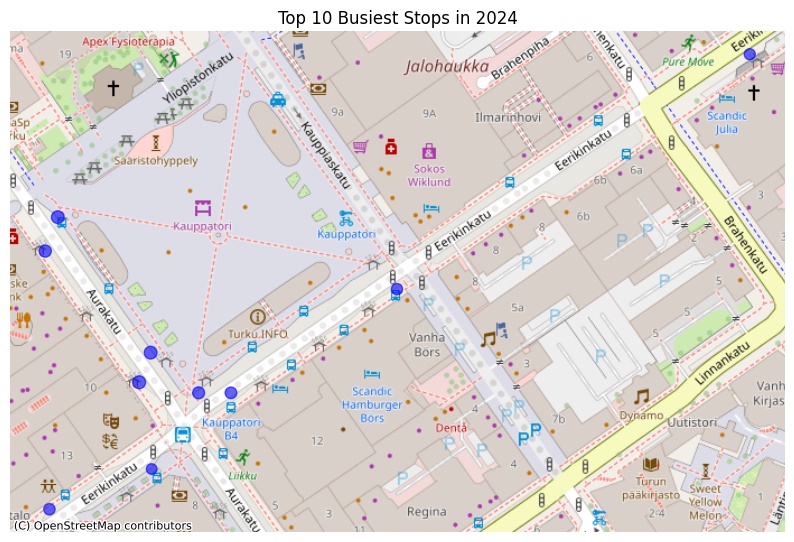

In [133]:
stop_top =  stop_data.sort_values(by='count', ascending=False).head(10)
stop_top_reset = stop_top.reset_index()[['stop', 'stop_name', 'count', 'stop_lat', 'stop_lon']]

import geopandas as gpd
from shapely.geometry import Point
stop_top_gdf = gpd.GeoDataFrame(
    stop_top_reset, 
    geometry=[Point(xy) for xy in zip(stop_top_reset['stop_lon'], stop_top_reset['stop_lat'])],
    crs="EPSG:4326" 
)
stop_top_gdf = stop_top_gdf.to_crs(epsg=3857)



fig, ax = plt.subplots(figsize=(10, 10))

stop_top_gdf.plot(ax=ax, 
               markersize=stop_top_gdf['count'] / 5000,  
               color='blue', 
               alpha=0.6)

ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

plt.title("Top 10 Busiest Stops in 2024")
plt.axis('off') 
plt.show()



Nine of the ten busiest stops in 2024 are located in the Market Square (Kauppatori) area, and the remaining one — Brahenkatu — is also in the city center.

This concentration of activity is natural, as the city center hosts most workplaces, shops, and leisure destinations.
However, it may also indicate that many trips are forced to pass through the center for transfers, reflecting a network structure with limited direct connections between outer districts.

An interactive map of the top 50 stops by ridership, ignoring stops with missing data is available as stop_map_top_50_stops.html

In [134]:


stop_data_2 = stop_data[stop_data['stop_lat'].notna() & stop_data['stop_lon'].notna()]
stop_top =  stop_data_2.sort_values(by='count', ascending=False).head(50)
stop_top_reset = stop_top.reset_index()[['stop', 'stop_name', 'count', 'stop_lat', 'stop_lon']]

m = folium.Map(location=[stop_top_reset['stop_lat'].mean(),
                         stop_top_reset['stop_lon'].mean()],
               zoom_start=13)


max_count = stop_top_reset['count'].max()
min_radius = 1
max_radius = 20

for _, row in stop_top_reset.iterrows():

    radius = min_radius + (row['count'] / max_count) * (max_radius - min_radius)
    
    folium.CircleMarker(
        location=[row['stop_lat'], row['stop_lon']],
        radius=radius,
        color='blue',
        fill=True,
        fill_opacity=0.6,
        popup=f"{row['stop_name']}: {row['count']} rides"
    ).add_to(m)


    m.save(HTML_DIR / "stop_map_top_50_stops.html")



We see that there is a big cluster of high ridership stops in Turku city center (around Market square and by the Cathedral), as well as a cluster around Kupittaa station (where trains from Helsinki terminated in 2024) and in the Varissuo neighnourhood in Eastern Turku. There are also high ridership stops in Runosmäki neighbourhood in Northern Turku, by the Turku bus station, Turku passenger harbour, Turku shipyard, towns of Raisio and Naantali (outside of Turku but covered by the bus system), by Mylly shopping mall and Kupittaa ice hockey arena. 

## Ridership by line

We now explore ridership for different lines.



In [135]:
print(len(ext_data_2024["line"].unique()))

187


We see there were 187 bus lines in total.

We now group by line.

In [136]:
line_rid = ext_data_2024.groupby("line")["count"].sum()
line_data = line_rid.reset_index()


Let us first find the most popular bus line.

In [137]:
top_line_index = line_data["count"].idxmax()
print(f"The most popular line in 2024 was line {line_data.iloc[top_line_index]["line"]}.")


The most popular line in 2024 was line 18.


We see that the most popular bus line in 2024 was number 18. 

Let's look in more detail at line 18 ridership. 
(Note that in 2025 the bus system in Turku changed substantially.)

We first look at the stops along the line and boarding numbers.


In [138]:
ext_data_line_18 = ext_data_2024[ext_data_2024['line'] == '18']
stops_line_18 = ext_data_line_18.groupby("stop")["count"].sum().reset_index()
stops_line_18_data = stops_line_18.merge(stops, how='left', left_on='stop', right_on='stop_id')


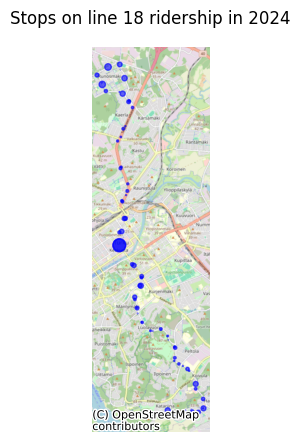

In [139]:
stops_line_18_gdf = gpd.GeoDataFrame(
    stops_line_18_data, 
    geometry=[Point(xy) for xy in zip(stops_line_18_data['stop_lon'], stops_line_18_data['stop_lat'])],
    crs="EPSG:4326"  # WGS84 latitude/longitude
)
stops_line_18_gdf = stops_line_18_gdf.to_crs(epsg=3857)


fig, ax = plt.subplots(figsize=(5, 5))

stops_line_18_gdf.plot(ax=ax, 
               markersize=stops_line_18_gdf['count'] / 5000, 
               color='blue', 
               alpha=0.6)

ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

plt.title("Stops on line 18 ridership in 2024")
plt.axis('off')  
plt.show()


We see that line 18 runs north-south through the city center, connecting it with many neighbourhoods, the biggest one in terms of ridership being Runosmäki in the north.

An interactive map is saved as stop_map_line_18.html

In [140]:


m = folium.Map(location=[stop_data_2['stop_lat'].mean(),
                         stop_data_2['stop_lon'].mean()],
               zoom_start=13)


scale_factor = 50

for _, row in stops_line_18_gdf.iterrows():
    
    folium.CircleMarker(
    location=[row['stop_lat'], row['stop_lon']],
    radius=max(1, (row['count'] ** 0.5) / scale_factor),
    popup=f"{row['stop_name']} ({row['count']} rides)",
    color='blue',
    fill=True,
    fill_opacity=0.6
).add_to(m)

    m.save(HTML_DIR / "stop_map_line_18.html")


Let's look at the total ridership of line 18 in 2024 and compare it to the ridership in the whole system in 2024.

In [141]:
total_passengers = ext_data_2024['count'].sum()
print(f"The total number of trips in 2024: {total_passengers :,}")

pass_total_line_18 = ext_data_line_18["count"].sum()
prop_line_18 = pass_total_line_18 / total_passengers * 100
print(f"The total number of trips on line 18 in 2024: {pass_total_line_18:,}, which is around \
{prop_line_18:.1f}% of the total number of trips in the system.")


The total number of trips in 2024: 24,807,995
The total number of trips on line 18 in 2024: 2,535,511, which is around 10.2% of the total number of trips in the system.


We see that just one line was providing more than 10% of the ridership of the whole system (which had 187 lines).


Let's now look when the proportion of line 18 ridership to total ridership is the smallest.

In [142]:
pass_by_date_line_18 = ext_data_line_18.groupby("date")["count"].sum().reset_index()
pass_by_date = ext_data_2024.groupby('date')['count'].sum().reset_index()
pass_by_date_line_18["prop_to_all"] = pass_by_date_line_18["count"] / pass_by_date["count"]


pass_by_date_line_18_diff_bottom = pass_by_date_line_18.sort_values(by="prop_to_all", ascending=True).head(5)
pass_by_date_line_18_diff_bottom = pass_by_date_line_18_diff_bottom.reset_index(drop=True)
pass_by_date_line_18_diff_bottom.columns = ['Date', 'Rides', 'Proportion']
pass_by_date_line_18_diff_bottom['Date'] = pd.to_datetime(pass_by_date_line_18_diff_bottom['Date'])
print("Five days with lowest proportion of rides on line 18 to all rides:")
display(pass_by_date_line_18_diff_bottom.style.hide(axis="index").format({
    "Date": lambda d: d.strftime('%Y-%m-%d'),
    "Rides": "{:,}",
    "Proportion": "{:.3f}"
}))






Five days with lowest proportion of rides on line 18 to all rides:


Date,Rides,Proportion
2024-12-31,13,0.054
2024-07-07,"2,568",0.070
2024-07-06,"3,831",0.071
2024-07-20,"5,059",0.080
2024-07-05,"5,695",0.086


Apart from Dec. 31st (probable data error), we get Ruisrock Festival days (05.07-07.07) and one of the Tall Ships Race in Turku days (20.07), those two latter probably due to the fact that bus route 18 was not relevant for those events' locations. 

Let's now look when the proportion of line 18 ridership to total ridership is the highest.

In [143]:
pass_by_date_line_18_diff_top = pass_by_date_line_18.sort_values(by="prop_to_all", ascending=False).head(5)
pass_by_date_line_18_diff_top = pass_by_date_line_18_diff_top.reset_index(drop=True)
pass_by_date_line_18_diff_top.columns = ['Date', 'Rides', 'Proportion']
pass_by_date_line_18_diff_top['Date'] = pd.to_datetime(pass_by_date_line_18_diff_top['Date'])
print("Five days with highest proportion of rides on line 18 to all rides:")
display(pass_by_date_line_18_diff_top.style.hide(axis="index").format({
    "Date": lambda d: d.strftime('%Y-%m-%d'),
    "Rides": "{:,}",
    "Proportion": "{:.3f}"
}))


Five days with highest proportion of rides on line 18 to all rides:


Date,Rides,Proportion
2024-02-02,"5,920",0.179
2024-02-14,"7,429",0.155
2024-02-15,"7,308",0.152
2024-12-25,"1,382",0.140
2024-12-24,"2,472",0.125


The first three days are strike days, so probably line 18 was running a more regular service on those days than some other lines. Also on Christmas Day and Christmas Eve line 18 was particularly popular.

Let us now look at the most popular bus lines.

In [144]:
top10_lines = line_data.sort_values(by="count", ascending=False).head(10)
top10_lines = top10_lines.reset_index(drop=True)
print("Ten lines with highest ridership in 2024:")
display(top10_lines.style.hide(axis="index"))


Ten lines with highest ridership in 2024:


line,count
18,2535511
42,1537088
32,1470478
7,1385732
6,1345983
9,1188489
12,1077844
1,1065482
60,957577
300,871127


Let's visualize line ridership with a bar plot.

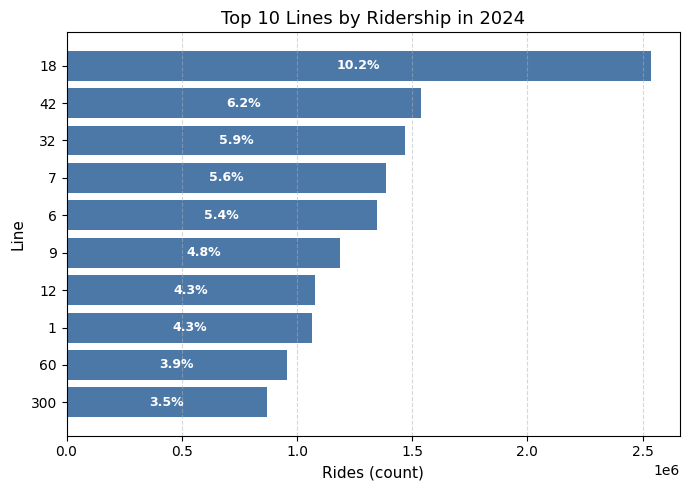

In [145]:
import matplotlib.pyplot as plt

# Sort and select top 10
lines_sorted = line_data.sort_values(by="count", ascending=False)
lines_sorted_top = lines_sorted.head(10).copy()

# Compute percentages
total_passengers = line_data["count"].sum()
lines_sorted_top["percent"] = 100 * lines_sorted_top["count"] / total_passengers

# Plot
plt.figure(figsize=(7, 5))
bars = plt.barh(lines_sorted_top["line"], lines_sorted_top["count"], color="#4C78A8")
plt.gca().invert_yaxis()

plt.xlabel("Rides (count)", fontsize=11)
plt.ylabel("Line", fontsize=11)
plt.title("Top 10 Lines by Ridership in 2024", fontsize=13)


for bar, pct in zip(bars, lines_sorted_top["percent"]):
    plt.text(bar.get_width() / 2,          
             bar.get_y() + bar.get_height()/2,
             f"{pct:.1f}%", 
             ha='center', va='center', color='white', fontsize=9, weight='bold')


plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


We see that line 18 has about 65% higher ridership than the second busiest line, number 42. After that the differences are not as big.

We see that top 10 lines cover more than the half of total ridership. This can be also illustrated by the share of total passengers visualization.

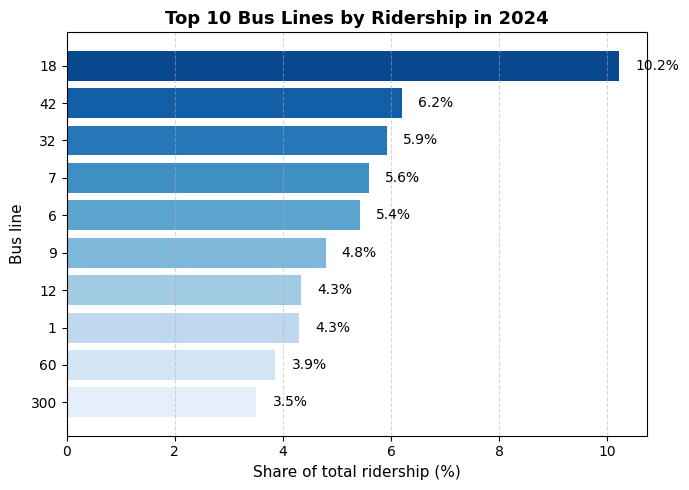

In [146]:

lines_sorted = line_data.sort_values(by="count", ascending=False)
lines_sorted_top = lines_sorted.head(10)

plt.figure(figsize=(7, 5))
colors = sns.color_palette("Blues_r", len(lines_sorted_top))
percents = (lines_sorted_top["count"] / total_passengers) * 100

plt.barh(lines_sorted_top["line"], percents, color=colors)
plt.gca().invert_yaxis()

for i, v in enumerate(percents):
    plt.text(v + 0.3, i, f"{v:.1f}%", va='center')

plt.xlabel("Share of total ridership (%)", fontsize=11)
plt.ylabel("Bus line", fontsize=11)
plt.title("Top 10 Bus Lines by Ridership in 2024", fontsize=13, weight='bold')
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


Let's also see on the map all 10 top ridership lines, with different colours. It is saved as stop_map_top10_lines.html

In [148]:


df = ext_data_2024.copy()
df['line'] = df['line'].astype(str)

top10_lines = (df.groupby('line', as_index=False)['count'].sum()
                 .sort_values('count', ascending=False)
                 .head(10)['line']
                 .tolist())

agg = (df[df['line'].isin(top10_lines)]
         .groupby(['line', 'stop'], as_index=False)['count'].sum())

cols_needed = ['stop_id', 'stop_name', 'stop_lat', 'stop_lon']
stops_slim = stops[cols_needed].copy()

top10 = (agg.merge(stops_slim, left_on='stop', right_on='stop_id', how='left')
            .dropna(subset=['stop_lat', 'stop_lon']))

center_lat = float(top10['stop_lat'].mean())
center_lon = float(top10['stop_lon'].mean())
m = folium.Map(location=[center_lat, center_lon], zoom_start=13, control_scale=True)

palette = [
    "#1f77b4","#ff7f0e","#2ca02c","#d62728","#9467bd",
    "#8c564b","#e377c2","#7f7f7f","#bcbd22","#17becf"
]
line_to_color = {line: palette[i % len(palette)] for i, line in enumerate(top10_lines)}

scale_divisor = 50.0  
min_radius = 3
max_radius = 18

for line, g in top10.groupby('line'):
    fg = folium.FeatureGroup(name=f"Line {line}", show=True)
    color = line_to_color[line]

    for _, row in g.iterrows():
        r = np.sqrt(row['count']) / scale_divisor
        r = float(np.clip(r, min_radius, max_radius))

        folium.CircleMarker(
            location=[row['stop_lat'], row['stop_lon']],
            radius=r,
            color=color,
            fill=True,
            fill_color=color,
            fill_opacity=0.6,
            weight=1,
            popup=folium.Popup(
                f"<b>{row['stop_name']}</b><br>Line {line}<br>{int(row['count']):,} rides",
                max_width=260
            ),
        ).add_to(fg)

    fg.add_to(m)

folium.LayerControl(collapsed=False).add_to(m)
m.save(HTML_DIR / "stop_map_top_10_lines.html")



We see that all the top 10 lines pass through the city center.

## Summary

**Overall ridership and data coverage**

The dataset covers the entire year 2024 except Jan. 1, with about 24.8 million total trips across all lines.
The average daily ridership was around 67,967 passengers, ranging from under 10,000 rides on Christmas day to over 110,000 rides on the busiest day, November 22.
The system shows strong weekday–weekend differences, and clear seasonal and holiday patterns.

**Weekly and daily patterns**

Weekdays dominate ridership, averaging about 79,700 rides per day, compared to only about 38,500 on weekend days, which represents roughly a 50 percent drop.
Within the week, ridership increases gradually from Monday to Friday, peaking at about 80,800 on Fridays.
Saturdays see a decline of around 40 percent, and Sundays about 65 percent relative to weekdays.
This indicates that public transport demand in Turku is primarily driven by commuting and school-related trips.

**Holidays and school breaks**

Public holidays show much lower ridership, about 29,000 rides per day, almost the same as on Sundays, compared to 81,500 on normal workdays.
On workdays that fall within school holidays, the ridership averages around 56,700, compared to about 90,200 on regular workdays.
This suggests that student commuting and education-related trips play an important role in weekday demand.

**Seasonal and monthly trends**

Ridership in 2024 varies strongly over the course of the year.
The first three months, January through March, show stable and relatively high demand, averaging between 71,000 and 77,000 rides per day. In May average drops to about 65,000 rides.
The lowest ridership levels occur during the summer months, June and July, when daily averages fall to around 49,000 rides. This drop coincides with school holidays and cottage season. Starting in August, ridership begins to recover, reaching around 62,000 rides, and continues to rise through September and October as regular work and school travel patterns resume.
The busiest period of the year is November, with an average of nearly 82,000 rides per day, likely reflecting increased travel before Christmas. December average shows a decline to around 67,000 rides as holiday periods begin.

**Spatial patterns: stops and lines**

The city center, particularly the Market Square (Kauppatori), dominates stop activity. Nine out of the ten busiest stops are located on the Market Square, with the only exception being Brahenkatu, also in the city center.
This reflects a radial/diametral network structure with most routes converging downtown, where many work and leisure destinations are located. The system structure also likely requires many passengers to transfer at the center.
The busiest line in 2024 was Line 18, carrying about 2.54 million rides, roughly 10 percent of all trips.
The ten most heavily used lines together account for about 54 percent of total ridership, indicating that a small number of lines handle the majority of passenger demand.
This concentration highlights the importance of high-frequency service corridors and efficient interchange points at key stops.

